<h2><center><font color='blue'> Calculation of Well Head Protection Areas using Capture Zone Analysis </center></h2>

<h3><font color='teal'><center> Venki Uddameri, Ph.D., P.E.

<hr>

The use of Theis solution for capture zone analysis does not account for the impacts of regional groundwater flow gradients.  As such, other tools for better delineation of capture zones are available.  A schematic description of the capture zones is shown below




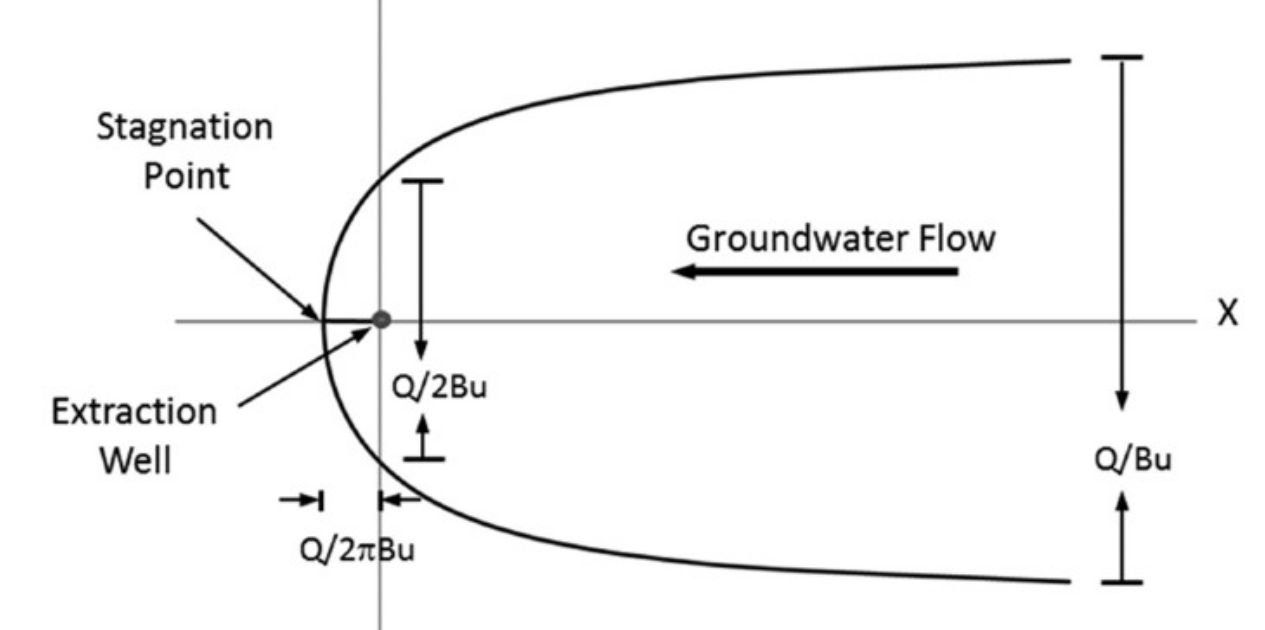

The figure above assumes the well is at a location (0,0).  The stagnation point refers to the point on the X-axis (downgradient of the flow) till which the pumping effects are felt.  The maximum width of the cpature zone along the Y-axis is also given.  We can also obtain the outer curve of the capture zone using the following equations.

$x_s = -\frac{Q}{2\pi BU} $  Where $x_s$ is the stagnation point.  Note as the well is at the origin, the stagnation point is negative

$y_{max} = \pm \frac{Q}{BU} $

For the capture zone boundary, the relationship between x and y is given as follows:

$ x = -\frac{y}{tan\left(\frac{2 \pi UB y}{Q}\right)} $

Where, U is the Darcy velocity (K.i) (ft/d); K is the hydraulic conductivity (ft/d); i is regional groundwater flow gradient.  Q is the pumping rate (ft$^3$/d); B is the aquifer thickness.  Note the product BU can also be written as the product Ti (where T is the aquifer transmissivity ft$^2$/d).  Note any set of consistent units can be used.  **If Albert Equal Area Conic** projection is used then the use of m for length dimension may come handy.  

<h4> Workflow

The computation entails the following steps.
<ol>
<li> Select the dimensions of study (L in m; t in Days); Q will be $m^3/d$ and BU = Ti = $m^2/d$ </li>
<li> Select projection to use.  Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350 </li>
<li> Select the Well Location (get lat-lon coordinates) convert to AEA projection </li>
<li> Extract Transmissivity values at the well (from interpolated T gpkg file) </li>
<li> Obtain the mean water levels (computed earlier) for wells in a gpkg fle </li>
<li> Convert the mean water levels file to AEA projection and compute X and Y coordinates </li>
<li> Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y </li>
<li> Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient </li>
<li> Compute the capture zone polygon in model coordinates (well is at 0,0) </li>
<li> Convert the capture zone polygon to AEA projection coordinates use suitable transformation </li>
<li> Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction</li>
<li> Create a shapely polygon (object) of the capture zone.  Export to a gpkg file
<li> Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.
</ol>

<h4> Import Libraries

In [99]:
# Import Libraries
import numpy as np
import pandas as pd
import os
from shapely.geometry import Point
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib_map_utils as mu # To draw north arrow
import statsmodels.api as sm
from matplotlib_scalebar.scalebar import ScaleBar # to draw scalebar
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
from pyproj import Transformer
from shapely.geometry import Polygon

<h4> Set Working Directory

In [100]:
path = 'C:/Users/Sushant/OneDrive - Lamar University/1st semester/GIS/Inclass assignment/2nd/TX_Waterwell'
os.chdir(path)

In [101]:
# Import all the GPKG files and conver then to AEA projection to plot
fname = 'PWells_GAM.gpkg'
Tval = gpd.read_file(fname)
Tvalaea = Tval.to_crs('EPSG:6350')  # Convert the point object to EPSG:6350 (Albers Equal Area)
fname2 = 'JeffersonWGS84.gpkg'
Jefferson = gpd.read_file(fname2)
Jeffaea = Jefferson.to_crs('EPSG:6350')
Tvalaea

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,T_SQFTDay,T_GPD_ft,top_1,bot_1,bot_2,bot_3,bot_4,bot_5,bot_6,geometry
0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000,3358,25120,7.84802,-7.15198,-423.0,-789.0,-986.0,-1533.111,-2221.0,POINT (166834.847 785849.276)
1,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571,3352,25072,7.76283,-7.23717,-408.0,-750.0,-943.0,-1469.906,-2155.0,POINT (166277.794 788553.163)
2,6161602,Jefferson,-94.407223,30.073611,Interpolated From Topo Map,300.0,29.300000,6.700000,3190,23864,11.34370,-3.65630,-422.0,-844.0,-1033.0,-1528.316,-2262.0,POINT (153372.144 778829.428)
3,6162303,Jefferson,-94.275555,30.089167,Interpolated From Topo Map,102.0,30.000000,8.000000,3336,24952,11.82590,-3.17410,-438.0,-848.0,-1054.0,-1640.914,-2336.0,POINT (166018.091 780777.008)
4,6162305,Jefferson,-94.291667,30.096389,Interpolated From Topo Map,208.0,31.000000,8.000000,3315,24797,11.60230,-3.39770,-431.0,-818.0,-1030.0,-1596.809,-2295.0,POINT (164452.693 781550.465)
5,6301301,Jefferson,-93.908612,29.968055,Interpolated From Topo Map,1000.0,-3.320000,15.320000,3247,24288,2.47877,-12.52123,-483.0,-1290.0,-1482.0,-2222.534,-2918.0,POINT (201635.486 768048.647)
6,6423201,Jefferson,-94.199722,29.742500,Interpolated From Topo Map,178.0,1.800000,3.200000,2850,21316,1.58218,-13.41782,-572.0,-1373.0,-1586.0,-2462.670,-3265.0,POINT (174046.516 742456.471)
7,6423302,Jefferson,-94.164167,29.741389,Interpolated From Topo Map,70.0,1.900000,1.100000,2902,21712,1.53150,-13.46850,-576.0,-1401.0,-1614.0,-2465.575,-3288.0,POINT (177485.844 742399.036)
8,6424502,Jefferson,-94.072778,29.667778,Interpolated From Topo Map,10.0,2.000000,3.000000,3032,22684,1.78449,-13.21551,-630.0,-1534.0,-1772.0,-2645.063,-3526.0,POINT (186485.561 734412.408)


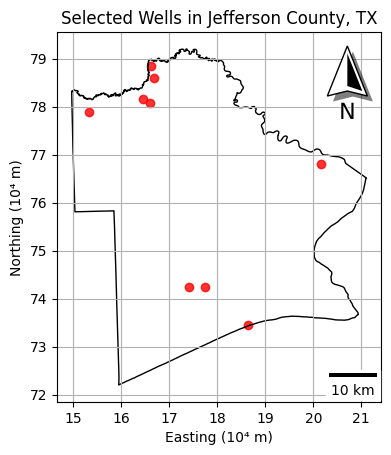

In [102]:
# Plot the well and the jefferson county to see if they match up

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar

# Function to scale the axis labels
def format_ticks(x, pos):
    return f'{x * 1e-4:.0f}'  # This example scales by 10^3; adjust if needed

fig, ax = plt.subplots()

# Plotting data with customized styles
Tvalaea.plot(ax=ax, facecolor='red', edgecolor='red', alpha=0.8)
Jeffaea.plot(ax=ax, facecolor='none', edgecolor='black')

# Adding the north arrow
mu.north_arrow.north_arrow(ax=ax, location='upper right', rotation={"degrees": 0})

# Adding a scale bar
scalebar = ScaleBar(1, units="m", location="lower right", length_fraction=0.2)
ax.add_artist(scalebar)

# Setting axis labels with a multiplier
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.set_xlabel('Easting (10⁴ m)')
ax.set_ylabel('Northing (10⁴ m)')

# Adding title and grid
plt.title('Selected Wells in Jefferson County, TX')
plt.grid()
plt.show()

<h2> 1. Select the dimensions of study (L in m; t in Days); Q will be $m^3/d$ and BU = Ti = $m^2/d$</h2>

In [103]:
# Population and per capita usage
Pop = 20000
pcu = 135  # gallons/day per capita

# Design time in years and other parameters
tyears = 10  # 10 years design time
S = 0.005  # Slope or another parameter (assumed from literature)

# Extract T values from Tval, assuming Tval is a DataFrame or Series with a column "T_SQFTDay"
T = list(Tval['T_SQFTDay'])  # Accessing the column "T_SQFTDay" from Tval as a list

# Convert T from square feet per day to square meters per day
BU = [value * 0.092903 for value in T]  # Using list comprehension to convert each T value

# Calculate pumping rate in cubic feet per day
Q = Pop * pcu * 0.133681  # Conversion factor for gallons to cubic feet
Q = Q * 0.0283168  # cubic feet to cubic meter
# Convert design time from years to days
t = tyears * 365.25  # Including leap year adjustment

# Print results
print("Transmissivity values (sq ft/day):", T)
print("Converted transmissivity values (sq m/day):", BU)
print("Pumping rate (cubic meter/day):", Q)
print("Design time (days):", t)

Transmissivity values (sq ft/day): [3358, 3352, 3190, 3336, 3315, 3247, 2850, 2902, 3032]
Converted transmissivity values (sq m/day): [311.968274, 311.410856, 296.36057, 309.92440799999997, 307.973445, 301.656041, 264.77355, 269.604506, 281.681896]
Pumping rate (cubic meter/day): 10220.62898016
Design time (days): 3652.5


<h2>2 Select projection to use. Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350</h2>

<h3 style="color: green;">Already done in previous section ✓✓</h3>

<h2>3. Select the Well Location (get lat-lon coordinates) convert to AEA projection</h2>

<h2>4. Extract Transmissivity values at the well (from interpolated T gpkg file)</h2>

<h2>5. Obtain the mean water levels (computed earlier) for wells in a gpkg file</h2>

In [104]:
Well_location = Tvalaea[['StateWellNumber','LatitudeDD','LongitudeDD', 'T_SQFTDay', 'WellDepth',	'WaterElevation',	'DepthFromLSD']]
Well_location
# Define the EPSG codes
wgs84_epsg = 4326  # WGS84 projection
aea_conus_epsg = 6350  # Albers Equal Area Conic (CONUS) projection

# Step 1: Create a GeoDataFrame from Well_location with WGS84 coordinates
Well_location['geometry'] = Well_location.apply(lambda row: Point(row['LongitudeDD'], row['LatitudeDD']), axis=1)
Well_location_gdf = gpd.GeoDataFrame(Well_location, geometry='geometry', crs=f"EPSG:{wgs84_epsg}")

# Step 2: Convert (reproject) to Albers Equal Area Conic (CONUS) projection
Well_location_aea = Well_location_gdf.to_crs(epsg=aea_conus_epsg)

# Step 3: Extract the X and Y coordinates in the AEA projection
Well_location_aea['longitude_aea'] = Well_location_aea.geometry.x
Well_location_aea['latitude_aea'] = Well_location_aea.geometry.y

#Add BU values to the data frame

Well_location_aea['BU'] = BU


C:\Users\Sushant\AppData\Local\ipykernel_5236\2419414636.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Well_location['geometry'] = Well_location.apply(lambda row: Point(row['LongitudeDD'], row['LatitudeDD']), axis=1)


<h2>Get the Mean water level for all the  wells for applying linear regression</h2>


<h2>6. Convert the mean water levels file to AEA projection and compute X and Y coordinates</h2>
<h2>7. Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y</h2>

In [105]:
# Load the CSV file into a DataFrame
GCMeanWL = pd.read_csv('GCMeanWL.csv')

# Define the EPSG codes
wgs84_epsg = 4326  # WGS84 projection
aea_conus_epsg = 6350  # Albers Equal Area Conic (CONUS) projection

# Step 1: Create a GeoDataFrame from GCMeanWL with WGS84 coordinates
GCMeanWL['geometry'] = GCMeanWL.apply(lambda row: Point(row['LongitudeDD'], row['LatitudeDD']), axis=1)
GCMeanWL_gdf = gpd.GeoDataFrame(GCMeanWL, geometry='geometry', crs=f"EPSG:{wgs84_epsg}")

# Step 2: Convert (reproject) to Albers Equal Area Conic (CONUS) projection
GCMeanWL_aea = GCMeanWL_gdf.to_crs(epsg=aea_conus_epsg)

# Step 3: Extract the X and Y coordinates in the AEA projection
GCMeanWL_aea['longitude_aea'] = GCMeanWL_aea.geometry.x
GCMeanWL_aea['latitude_aea'] = GCMeanWL_aea.geometry.y


In [106]:
# For demonstration, let's assume LandElevation is a constant or you can use a column from your original DataFrame
# For example, let's assume a constant value for LandElevation (replace with actual data if available)

# Step 2: Prepare data for linear regression
# X variables (longitude and latitude)
X = GCMeanWL_aea[['longitude_aea', 'latitude_aea']]
# Add a constant to the model (intercept)
X = sm.add_constant(X)
# Y variable (hydraulic head)
Y = GCMeanWL_aea['WaterElevation']

# Step 3: Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Step 4: Print the regression results
print(model.summary())

# Optional: Get coefficients
coefficients = model.params
print("Coefficients:\n", coefficients)

                            OLS Regression Results                            
Dep. Variable:         WaterElevation   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     26.24
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           9.67e-11
Time:                        23:35:08   Log-Likelihood:                -758.51
No. Observations:                 185   AIC:                             1523.
Df Residuals:                     182   BIC:                             1533.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -79.7174     68.549     -1.163

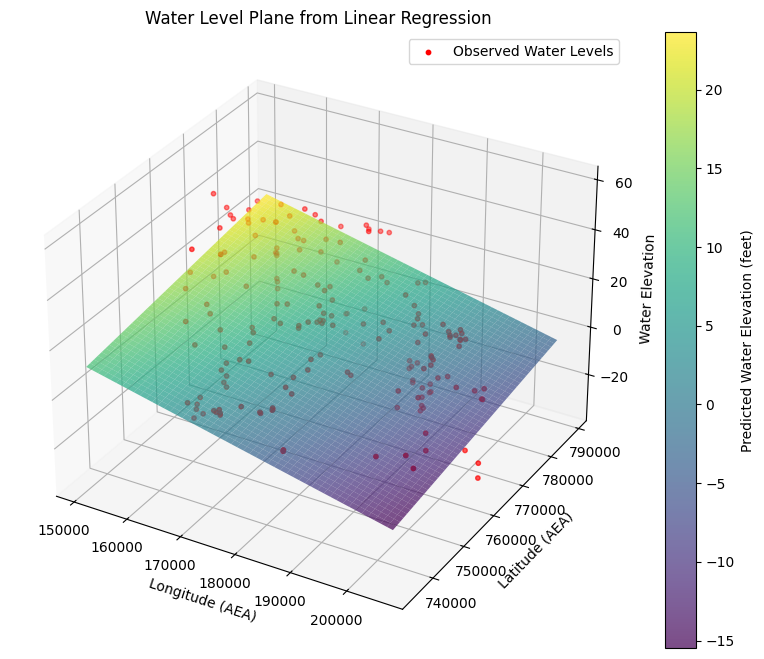

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Regression coefficients
beta_0 = -79.717450  # Intercept
beta_1 = -0.000500   # Longitude coefficient
beta_2 = 0.000227    # Latitude coefficient

# Define the grid range based on min/max of your data
x_min, x_max = GCMeanWL_aea['longitude_aea'].min(), GCMeanWL_aea['longitude_aea'].max()
y_min, y_max = GCMeanWL_aea['latitude_aea'].min(), GCMeanWL_aea['latitude_aea'].max()

# Create a grid of X and Y values
x_values = np.linspace(x_min, x_max, 1000)
y_values = np.linspace(y_min, y_max, 1000)
X, Y = np.meshgrid(x_values, y_values)

# Calculate the Z values (predicted water elevation) for each (X, Y) point
Z = beta_0 + beta_1 * X + beta_2 * Y

# Plot the plane in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the regression plane
surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.7)
fig.colorbar(surf, ax=ax, label='Predicted Water Elevation (feet)')

# Extract longitude and latitude from X for plotting
longitude_values = GCMeanWL_aea['longitude_aea']  # 1D array of longitudes
latitude_values = GCMeanWL_aea['latitude_aea']    # 1D array of latitudes
water_elevation_values = GCMeanWL_aea['WaterElevation']  # 1D array of water elevations

# Add original well data points for reference
ax.scatter(longitude_values, latitude_values, water_elevation_values,
           color='red', marker='o', s=10, label='Observed Water Levels')

# Label axes
ax.set_xlabel("Longitude (AEA)")
ax.set_ylabel("Latitude (AEA)")
ax.set_zlabel("Water Elevation")

plt.title("Water Level Plane from Linear Regression")
plt.legend()
plt.show()

<h2>Calculate Gradient</h2> <h3 style="color: green;">✓✓</h3>

In [108]:
# Step 4: Calculate gradients
beta_1 = coefficients['longitude_aea']  # Gradient in the X direction (longitude)
beta_2 = coefficients['latitude_aea']    # Gradient in the Y direction (latitude)

# Step 5: Calculate the resultant gradient
resultant_gradient = np.sqrt(beta_1**2 + beta_2**2)
i = resultant_gradient
# Print the gradients and resultant gradient
print(f"Gradient along X (longitude): {beta_1:.6f}")
print(f"Gradient along Y (latitude): {beta_2:.6f}")
print(f"Resultant Gradient: {resultant_gradient:.6f}")
print(f"i: {i:.6f}")

Gradient along X (longitude): -0.000500
Gradient along Y (latitude): 0.000227
Resultant Gradient: 0.000549
i: 0.000549


<h2>9. Compute the capture zone polygon in model coordinates (well is at 0,0)</h2>

$x_s = -\frac{Q}{2\pi BU} $  Where $x_s$ is the stagnation point.  Note as the well is at the origin, the stagnation point is negative

$y_{max} = \pm \frac{Q}{BU} $

In [109]:
# Stagnation Point
T = BU
x_s = Well_location_aea['longitude_aea']- Q / (2 * np.pi * np.array(T))

# Y at well location (0,0)
y_well_upper = Well_location_aea['latitude_aea'] + (Q/ (4 * np.array(T)*i))
y_well_lower = Well_location_aea['latitude_aea'] - (Q/ (4 * np.array(T)*i))

<h3> For the capture zone boundary, the relationship between x and y is given as follows: </h3>

$ x = -\frac{y}{tan\left(\frac{2 \pi UB y}{Q}\right)} $

It becoms
$ x = -\frac{y}{tan\left(\frac{2 \pi T y}{Q}\right)}$

Calculating x, when y = Q/2Ti

In [110]:
# Get x values at the maximum height
y_max = Q/ 2 * np.pi * np.array(T)*i
y_min = -Q/ 2 * np.pi * np.array(T)*i
x_max = -(y_max / np.tan((2 * np.pi * np.array( T) * y_max) / Q)) # Maximum x coordinates

y_well_max_upper = Well_location_aea['latitude_aea'] + Q / (2 * np.array(T) * i)
y_well_max_lower = Well_location_aea['latitude_aea'] - Q / (2 * np.array(T) * i)

# Maximum and minimum y coordinates
y_max_Lat_long = Well_location_aea['latitude_aea'] + y_well_max_upper

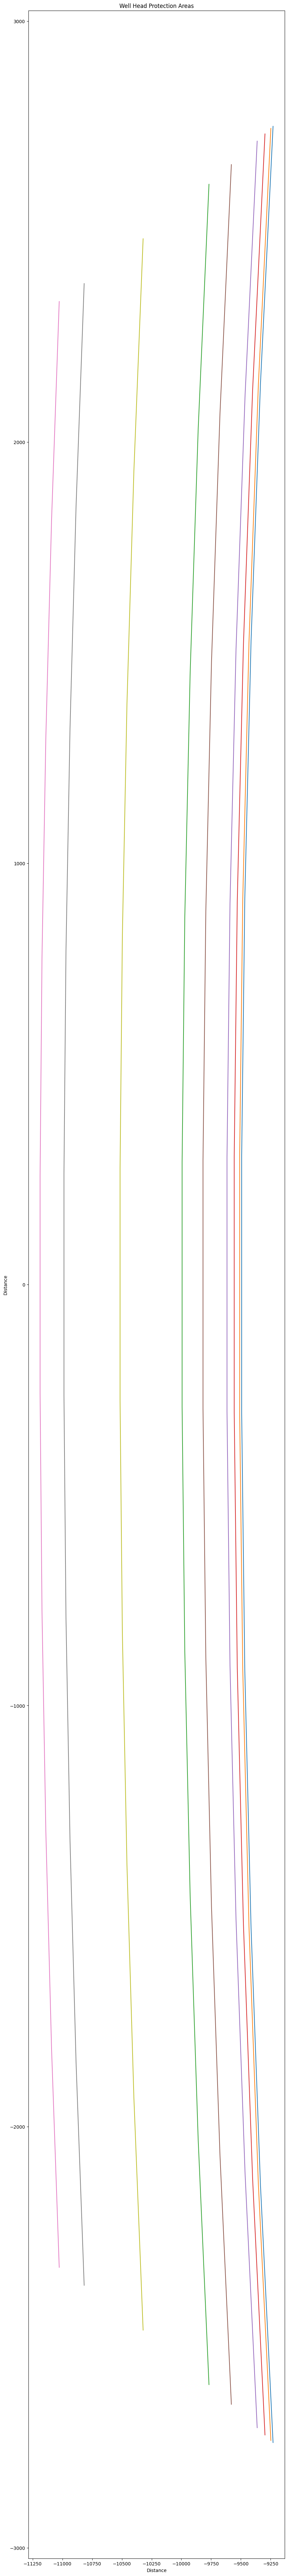

In [111]:
# Plot them
plt.figure(figsize=(10, 100))
for z in range(0,9):
    lin_spa = np.linspace(y_min[z],y_max[z],10)
    x = -(lin_spa / np.tan((2 * np.pi * T[z] * lin_spa) / Q))
    # Calculate x using the boundary equation
    x = -lin_spa / np.tan((2 * np.pi *  T[z] *i * lin_spa) / Q)  # x in meters

    
    plt.plot(x, lin_spa, label='Well Head Protection Areas')
    plt.xlabel('Distance')
    plt.ylabel('Distance')
    plt.title('Well Head Protection Areas')


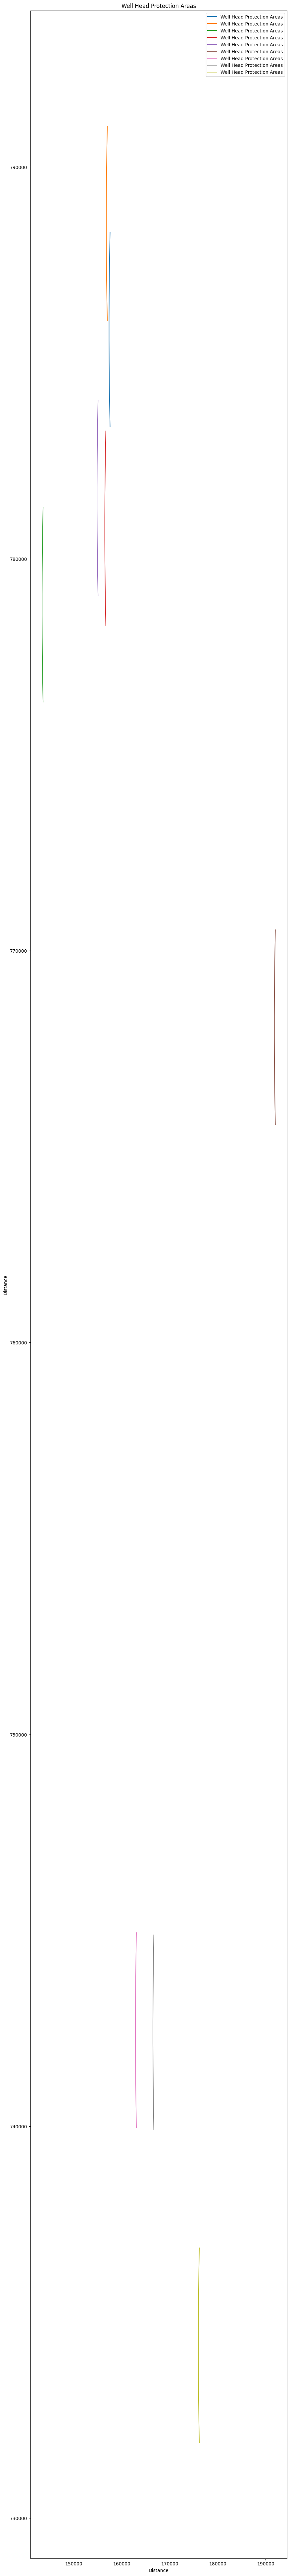

In [112]:
# Plotting

plt.figure(figsize=(10, 100))
for z in range(0,9):
    x = x_s.iloc[z] + (-(lin_spa / np.tan((2 * np.pi * T[z] *i* lin_spa) / Q)))
    y = Well_location_aea['latitude_aea'].iloc[z] + lin_spa

    
    plt.plot(x, y, label='Well Head Protection Areas')
    plt.xlabel('Distance')
    plt.ylabel('Distance')
    plt.legend()
    plt.title('Well Head Protection Areas')

C:\Users\Sushant\AppData\Local\ipykernel_5236\533676269.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


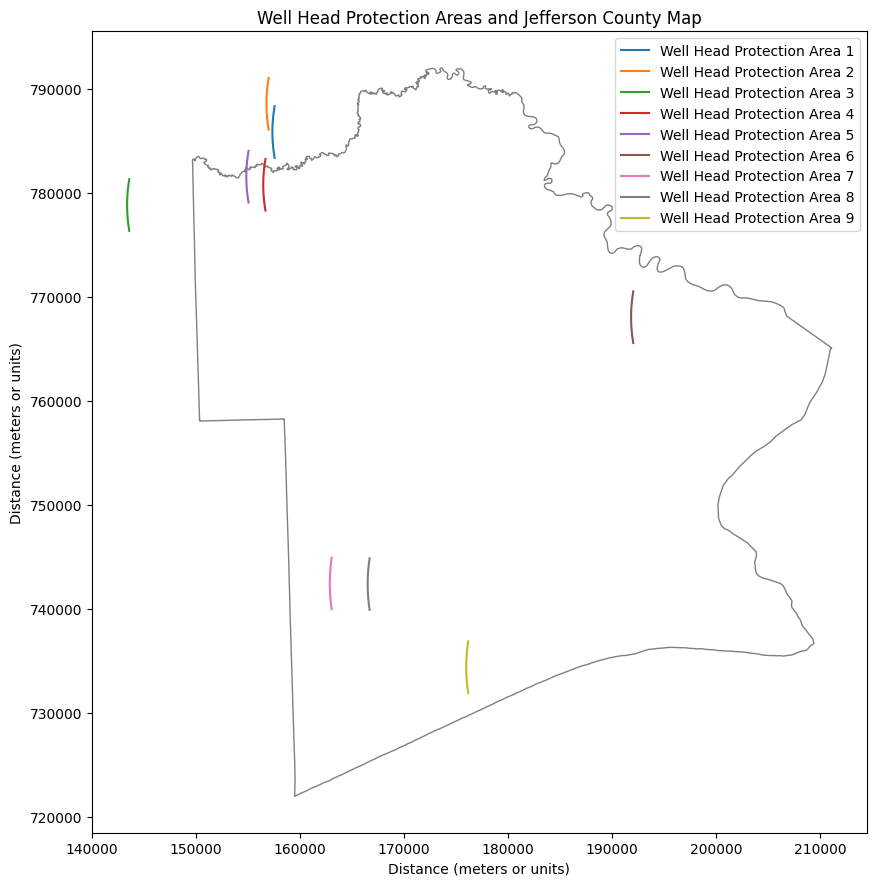

In [113]:
# Create a figure and axis
plt.figure(figsize=(10, 100))

# Plot Jefferson County map
Jeffaea.plot(ax=plt.gca(), color='none', edgecolor='black', alpha=0.5, label='Jefferson County')
Tvalaea.plot(ax=ax, facecolor='red', edgecolor='red', alpha=1)
# Plot Well Head Protection Areas
for z in range(0, 9):
    x = x_s.iloc[z] + (-(lin_spa / np.tan((2 * np.pi * T[z] * i * lin_spa) / Q)))
    y = Well_location_aea['latitude_aea'].iloc[z] + lin_spa
    
    plt.plot(x, y, label=f'Well Head Protection Area {z+1}')
    
# Set labels, title, and legend
plt.xlabel('Distance (meters or units)')
plt.ylabel('Distance (meters or units)')
plt.legend()
plt.title('Well Head Protection Areas and Jefferson County Map')
# Adding the north arrow
mu.north_arrow.north_arrow(ax=ax, location='upper right', rotation={"degrees": 0})

# Adding a scale bar
scalebar = ScaleBar(1, units="m", location="lower right", length_fraction=0.2)
ax.add_artist(scalebar)
# Display the plot
plt.show()

C:\Users\Sushant\AppData\Local\ipykernel_5236\2695069002.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


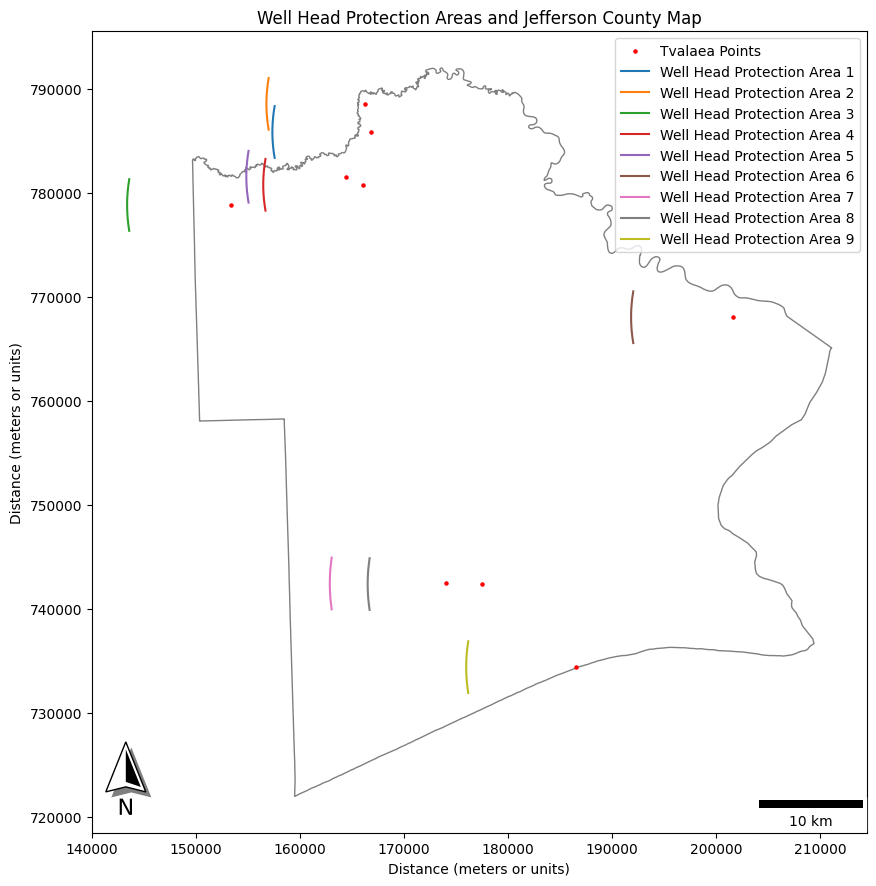

In [114]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 100))

# Plot Jefferson County map
Jeffaea.plot(ax=ax, color='none', edgecolor='black', alpha=0.5, label='Jefferson County')

# Plot Tvalaea (assuming Tvalaea is a GeoDataFrame with points or geometries)
Tvalaea.plot(ax=ax, color='red', marker='o', markersize=5, label='Tvalaea Points', alpha=1)

# Plot Well Head Protection Areas
for z in range(0, 9):
    x = x_s.iloc[z] + (-(lin_spa / np.tan((2 * np.pi * T[z] * i * lin_spa) / Q)))
    y = Well_location_aea['latitude_aea'].iloc[z] + lin_spa
    
    plt.plot(x, y, label=f'Well Head Protection Area {z+1}')

# Set labels, title, and legend
plt.xlabel('Distance (meters or units)')
plt.ylabel('Distance (meters or units)')
plt.legend()
plt.title('Well Head Protection Areas and Jefferson County Map')

# Adding the north arrow
mu.north_arrow.north_arrow(ax=ax, location='lower left', rotation={"degrees": 0})

# Adding a scale bar
scalebar = ScaleBar(1, units="m", location="lower right", length_fraction=0.2)
ax.add_artist(scalebar)

# Display the plot
plt.show()

C:\Users\Sushant\AppData\Local\ipykernel_5236\460130729.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


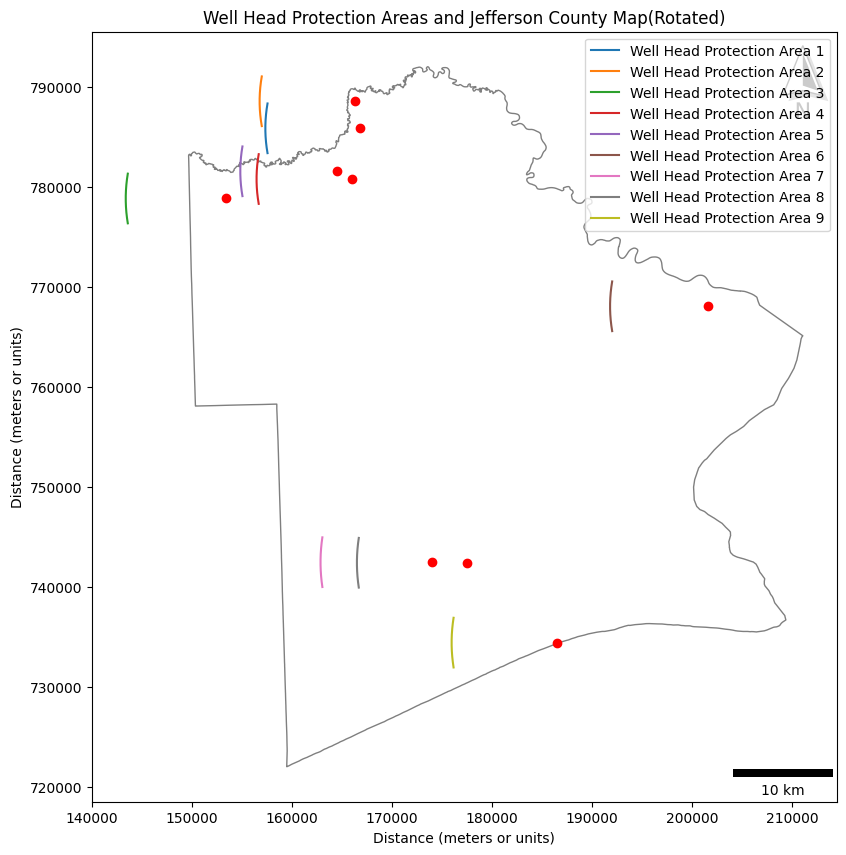

In [115]:
# Assuming you have the necessary data loaded into the variables like Jeffaea, Tvalaea, Well_location_aea, etc.

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Jefferson County map
Jeffaea.plot(ax=ax, color='none', edgecolor='black', alpha=0.5, label='Jefferson County')
Tvalaea.plot(ax=ax, facecolor='red', edgecolor='red', alpha=1)

# Plot Well Head Protection Areas
for z in range(0, 9):
    x = x_s.iloc[z] + (-(lin_spa / np.tan((2 * np.pi * T[z] * i * lin_spa) / Q)))
    y = Well_location_aea['latitude_aea'].iloc[z] + lin_spa
    
    ax.plot(x, y, label=f'Well Head Protection Area {z+1}')

# Set labels, title, and legend
ax.set_xlabel('Distance (meters or units)')
ax.set_ylabel('Distance (meters or units)')
ax.legend()
ax.set_title('Well Head Protection Areas and Jefferson County Map(Rotated)')

# Adding the north arrow
mu.north_arrow.north_arrow(ax=ax, location='upper right', rotation={"degrees": 0})

# Adding a scale bar
scalebar = ScaleBar(1, units="m", location="lower right", length_fraction=0.2)
ax.add_artist(scalebar)

# Display the plot
plt.show()

# Rotation code using lat/lon logic (as described)
# For example, rotating the figure by specific lat/lon differences
# Not fully implemented but here's how you'd handle rotation by latitude/longitude

In [117]:
# Define the coordinates of the polygon
polygon_coords = [
    (x_s.iloc[0], Well_location_aea['latitude_aea'].iloc[0]),
    (x_s.iloc[1], Well_location_aea['latitude_aea'].iloc[1]),
    (x_s.iloc[2], Well_location_aea['latitude_aea'].iloc[2]),
    (x_s.iloc[3], Well_location_aea['latitude_aea'].iloc[3]),
    (x_s.iloc[4], Well_location_aea['latitude_aea'].iloc[4]),
    (x_s.iloc[5], Well_location_aea['latitude_aea'].iloc[5]),
    (x_s.iloc[6], Well_location_aea['latitude_aea'].iloc[6]),
    (x_s.iloc[7], Well_location_aea['latitude_aea'].iloc[7]),
    (x_s.iloc[8], Well_location_aea['latitude_aea'].iloc[8]),
    (x_s.iloc[9], Well_location_aea['latitude_aea'].iloc[9]),


# Create a Shapely Polygon object
capture_zone_polygon = Polygon(polygon_coords)

# Create a GeoDataFrame for the capture zone
gdf_capture_zone = gpd.GeoDataFrame(geometry=[capture_zone_polygon])

# Save to a GeoPackage (GPKG) file
gdf_capture_zone.to_file("capture_zone.gpkg", driver="GPKG")


C:\Users\Sushant\anaconda3\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
